In [1]:
# cloned from https://github.com/eriklindernoren/PyTorch-GAN

import os
# os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID' 
# os.environ['CUDA_VISIBLE_DEVICES']='4,5,6,7'

import time
import itertools
import requests

import numpy as np
import matplotlib.pyplot as plt
import h5py
import random

import torch
from torch.optim import Adam

import torchvision.models.resnet as resnet

from torch.utils.data import DataLoader, TensorDataset
import torchvision.utils as vutils
import torch.autograd as autograd
# from torch.nn.utils import weight_norm

from cyclegan.model import Discriminator, Generator
from cyclegan.model import weights_init

import wandb

# import torch.backends.cudnn as cudnn
# cudnn.benchmark = True

from torch.backends import cudnn
cudnn.benchmark = True

device1 = torch.device("cuda:0")
device2 = torch.device("cuda:0")
device3 = torch.device("cuda:0")
device4 = torch.device("cuda:0")

In [2]:
SEND = 'https://api.telegram.org/bot'+os.environ['TG']+'/'

def send(text):
    return requests.post(SEND+'sendMessage', json={'chat_id': 80968060, 'text': text}).json()['result']['message_id']

def update_msg(text, msg_id):
    return requests.post(SEND+'editMessageText', json={'chat_id': 80968060, 'text': text, 'message_id': msg_id})

In [3]:
class DecayLR:
    def __init__(self, epochs, offset, decay_epochs):
        epoch_flag = epochs - decay_epochs
        assert (epoch_flag > 0), "Decay must start before the training session ends!"
        self.epochs = epochs
        self.offset = offset
        self.decay_epochs = decay_epochs

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_epochs) / (
                self.epochs - self.decay_epochs)
    
class ReplayBuffer:
    def __init__(self, max_size=50):
        assert (max_size > 0), "Empty buffer or trying to create a black hole. Be careful."
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return torch.cat(to_return)
    
def sample_data(loader):
    while True:
        for batch in loader:
            yield batch

In [4]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

img_size = 128
batch_size = 8
num_workers = 1

transform = transforms.Compose([
#     transforms.Resize([img_size, img_size]),
#     transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5]),
])

dsA = ImageFolder('data/mai/wsi1/', transform)
dsB = ImageFolder('data/mai/wsi2/', transform)

trainloader_A = DataLoader(dsA, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True, drop_last=True)
trainloader_B = DataLoader(dsB, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True, drop_last=True)

dsA.__len__(), dsB.__len__()

(27053, 26808)

In [5]:
class ResNet(resnet.ResNet):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.sigmoid(self._forward_impl(x))
    
@torch.no_grad()
def eval_G(G, clf, validation_loader, g_device, clf_device):
    G.eval()
    acc = .0
    for i, data in enumerate(validation_loader):
        X = data[0].to(g_device)
        y = data[1].to(clf_device)
        X_g = G(X).to(clf_device)
        predicted = torch.round(clf(0.5 * (X_g + 1.0)))
        acc+=(predicted == y).sum()/float(predicted.shape[0])     
#             acc_g+=(predicted_g == y).sum()/float(predicted_g.shape[0])     
    G.train()
    return (acc/(i+1)).detach().item()

@torch.no_grad()
def eval_Clf(model, validation_loader, device):
    acc = .0
    for i, data in enumerate(validation_loader):
        X = data[0].to(device)
        y = data[1].to(device)
        predicted = torch.round(model(0.5 * (X + 1.0)))
        acc+=(predicted == y).sum()/float(predicted.shape[0])       
    return (acc/(i+1)).detach().item()

In [6]:
netG_B2A = Generator().to(device1)
netD_A = Discriminator().to(device1)
netG_A2B = Generator().to(device2)
netD_B = Discriminator().to(device2)

netG_A2B.apply(weights_init)
netG_B2A.apply(weights_init)
netD_A.apply(weights_init)
netD_B.apply(weights_init)

cycle_loss1 = torch.nn.L1Loss().to(device1)
cycle_loss2 = torch.nn.L1Loss().to(device2)
identity_loss1 = torch.nn.L1Loss().to(device1)
identity_loss2 = torch.nn.L1Loss().to(device2)
adversarial_loss1 = torch.nn.MSELoss().to(device1)
adversarial_loss2 = torch.nn.MSELoss().to(device2)

def r1(output, imgs, gamma=10):
    grad_real = torch.autograd.grad(outputs=output, inputs=imgs, create_graph=True)[0]
    grad_penalty_real = (grad_real.view(grad_real.size(0), -1).norm(2, dim=1) ** 2).mean()
    return (gamma/2) * grad_penalty_real


# lambda_gp = 10
lr = 0.0002
betas = (0.5, 0.999)
# itertools.chain takes a series of iterables and return them as one long iterable.
optimizer_G = Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()), lr=lr, betas=betas)
optimizer_D_A = Adam(netD_A.parameters(), lr=lr, betas=betas)
optimizer_D_B = Adam(netD_B.parameters(), lr=lr, betas=betas)

epochs = 200
decay_epochs = 100
lr_lambda = DecayLR(epochs, 0, decay_epochs).step
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lr_lambda)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=lr_lambda)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=lr_lambda)

g_losses = []
d_losses_A = []
d_losses_B = []
acc_a = []
acc_b = []

identity_losses = []
gan_losses = []
cycle_losses = []

fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

In [ ]:
project = 'cyclegan_mai128'
run_name = 'lsgan_r1'
folder=project+'_'+run_name

msg_id = send(folder+': 0')

run = wandb.init(project=project)
wandb.run.name = run_name
wandb.run.save()

path = 'results/'+folder
path_imgs = path +'/samples'
if not os.path.exists('results'):
    os.mkdir('results')
if not os.path.exists(path):
    os.mkdir(path)
if not os.path.exists(path_imgs):
    os.mkdir(path_imgs)
if not os.path.exists(path_imgs+'/A'):
    os.mkdir(path_imgs+'/A')
if not os.path.exists(path_imgs+'/B'):
    os.mkdir(path_imgs+'/B')
    
best_acc_A = 0
best_acc_B = 0

early_stop_cnt = 0

iter_A = sample_data(trainloader_A)
iter_B = sample_data(trainloader_B)

total_iter = 100000

for i in range(1, total_iter+1):
    data_A = next(iter_A)[0]
    data_B = next(iter_B)[0]

    # get batch size data
    real_image_A1 = data_A.to(device1).requires_grad_()
    real_image_B1 = data_B.to(device1).requires_grad_()

    batch_size = real_image_A1.size(0)

    # real data label is 1, fake data label is 0.
    real_label1 = torch.full((batch_size, 1), 1, device=device1, dtype=torch.float32)
    fake_label1 = torch.full((batch_size, 1), 0, device=device1, dtype=torch.float32)
    real_label2 = torch.full((batch_size, 1), 1, device=device2, dtype=torch.float32)
    fake_label2 = torch.full((batch_size, 1), 0, device=device2, dtype=torch.float32)

    ##############################################
    # (1) Update G network: Generators A2B and B2A
    ##############################################

    # Set G_A and G_B's gradients to zero
    optimizer_G.zero_grad()

    # Identity loss
    # G_B2A(A) should equal A if real A is fed
    identity_image_A = netG_B2A(real_image_A1)
    loss_identity_A = identity_loss1(identity_image_A, real_image_A1) * 5.0
    # G_A2B(B) should equal B if real B is fed
    identity_image_B = netG_A2B(real_image_B1)
    loss_identity_B = identity_loss2(identity_image_B, real_image_B1) * 5.0

    # GAN loss D_A(G_A(A))
    fake_image_A = netG_B2A(real_image_B1)
    fake_output_A = netD_A(fake_image_A)
    loss_GAN_B2A = adversarial_loss1(fake_output_A, real_label1)
    # WGAN
#     loss_GAN_B2A = -fake_output_A.mean()

    # GAN loss D_B(G_B(B))
    fake_image_B = netG_A2B(real_image_A1)
    fake_output_B = netD_B(fake_image_B)
    loss_GAN_A2B = adversarial_loss2(fake_output_B, real_label2)
#     WGAN
#     loss_GAN_A2B = -fake_output_B.mean()

    # Cycle loss
    recovered_image_A = netG_B2A(fake_image_B)
    loss_cycle_ABA = cycle_loss1(recovered_image_A, real_image_A1) * 10.0

    recovered_image_B = netG_A2B(fake_image_A)
    loss_cycle_BAB = cycle_loss2(recovered_image_B, real_image_B1) * 10.0

    torch.cuda.synchronize()
    # Combined loss and calculate gradients
    errG = loss_identity_A.cpu() + loss_identity_B.cpu() + loss_GAN_A2B.cpu() + loss_GAN_B2A.cpu() + loss_cycle_ABA.cpu() + loss_cycle_BAB.cpu()

    g_losses.append(errG.item())
    # Calculate gradients for G_A and G_B
    errG.backward()
    # Update G_A and G_B's weights
    optimizer_G.step()

    ##############################################
    # (2) Update D network: Discriminator A
    ##############################################

    # Set D_A gradients to zero
    optimizer_D_A.zero_grad()

    # Real A image loss
    real_output_A = netD_A(real_image_A1)
    errD_real_A = adversarial_loss1(real_output_A, real_label1) + r1(real_output_A.sum(), real_image_A1)

    # Fake A image loss
    fake_image_A = fake_A_buffer.push_and_pop(fake_image_A)
    fake_output_A = netD_A(fake_image_A.detach())
    errD_fake_A = adversarial_loss1(fake_output_A, fake_label1)

    # Combined loss and calculate gradients
    errD_A = (errD_real_A + errD_fake_A) / 2

    d_losses_A.append(errD_A.item())

    # Calculate gradients for D_A
    errD_A.backward()
    # Update D_A weights
    optimizer_D_A.step()

    ##############################################
    # (3) Update D network: Discriminator B
    ##############################################

    # Set D_B gradients to zero
    optimizer_D_B.zero_grad()

    # Real B image loss
    real_output_B = netD_B(real_image_B1)
    errD_real_B = adversarial_loss2(real_output_B, real_label2) + r1(real_output_B.sum(), real_image_B1)
    # WGAN
#     errD_real_B = real_output_B.mean()

    # Fake B image loss
    fake_image_B = fake_B_buffer.push_and_pop(fake_image_B)
    fake_output_B = netD_B(fake_image_B.detach())
    errD_fake_B = adversarial_loss2(fake_output_B, fake_label2)
    # WGAN
#     errD_fake_B = fake_output_B.mean()

    # Combined loss and calculate gradients
    errD_B = (errD_real_B + errD_fake_B) / 2
    # WGAN
#     gp_B = gradient_penalty(netD_B, real_image_B1, netG_A2B(real_image_A1), device2)
#     errD_B = (errD_fake_B - errD_real_B + gp_B)

    d_losses_B.append(errD_B.item())

    # Calculate gradients for D_B
    errD_B.backward()
    # Update D_B weights
    optimizer_D_B.step()
        
#     torch.cuda.synchronize()
    if i%100 == 0:
        update_msg(folder+': '+str(i/total_iter), msg_id)
#         accA = eval_G(netG_B2A, ClfA, testloader1, device1, device3)
#         accB = eval_G(netG_A2B, ClfB, testloader0, device2, device4)
        
#         acc_a.append(accA)
#         acc_b.append(accB)

#         print(
#             f"{i:06d}\t"
#             f"{d_losses_A[-1]:2.4f}\t"
#             f"{d_losses_B[-1]:2.4f}\t"
#             f"{g_losses[-1]:2.4f}\t"
#             f"{accA:2.4f}\t"
#             f"{accB:2.4f}")
        
        wandb.log(
            {
                "d_losses_A": d_losses_A[-1],
                "d_losses_B": d_losses_B[-1],
                "g_losses": g_losses[-1],
            }
        )
    

    if i%1000 == 0:
        # Update learning rates
        lr_scheduler_G.step()
        lr_scheduler_D_A.step()
        lr_scheduler_D_B.step()

send(folder+' done')

wandb.save(path+"/netG_B2A.pth")
wandb.save(path+"/netD_A.pth")
wandb.save(path+"/netG_A2B.pth")
wandb.save(path+"/netD_B.pth")
    
torch.save(netG_A2B.state_dict(), path+"/netG_A2B_last.pth")
torch.save(netG_B2A.state_dict(), path+"/netG_B2A_last.pth")
torch.save(netD_A.state_dict(), path+"/netD_A_last.pth")
torch.save(netD_B.state_dict(), path+"/netD_B_last.pth")

np.save(path+'/d_losses_A.npy', d_losses_A)
np.save(path+'/d_losses_B.npy', d_losses_B)
np.save(path+'/g_losses.npy', g_losses)
np.save(path+'/acc_a.npy', acc_a)
np.save(path+'/acc_b.npy', acc_b)

run.finish()

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Currently logged in as: array (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.27 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


In [1]:
from torchsummary import summary
from cyclegan.model import Generator as CycleGANGenerator
from cyclegan.model import Discriminator as CycleGANDiscriminator

In [2]:
summary(CycleGANGenerator().cuda(), (3, 128, 128), batch_size=8)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1           [8, 3, 134, 134]               0
            Conv2d-2          [8, 64, 128, 128]           9,472
    InstanceNorm2d-3          [8, 64, 128, 128]               0
              ReLU-4          [8, 64, 128, 128]               0
            Conv2d-5           [8, 128, 64, 64]          73,856
    InstanceNorm2d-6           [8, 128, 64, 64]               0
              ReLU-7           [8, 128, 64, 64]               0
            Conv2d-8           [8, 256, 32, 32]         295,168
    InstanceNorm2d-9           [8, 256, 32, 32]               0
             ReLU-10           [8, 256, 32, 32]               0
  ReflectionPad2d-11           [8, 256, 34, 34]               0
           Conv2d-12           [8, 256, 32, 32]         590,080
   InstanceNorm2d-13           [8, 256, 32, 32]               0
             ReLU-14           [8, 256,

In [3]:
summary(CycleGANDiscriminator().cuda(), (3, 128, 128), batch_size=8)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [8, 64, 64, 64]           3,136
         LeakyReLU-2            [8, 64, 64, 64]               0
            Conv2d-3           [8, 128, 32, 32]         131,200
    InstanceNorm2d-4           [8, 128, 32, 32]               0
         LeakyReLU-5           [8, 128, 32, 32]               0
            Conv2d-6           [8, 256, 16, 16]         524,544
    InstanceNorm2d-7           [8, 256, 16, 16]               0
         LeakyReLU-8           [8, 256, 16, 16]               0
            Conv2d-9           [8, 512, 15, 15]       2,097,664
   InstanceNorm2d-10           [8, 512, 15, 15]               0
        LeakyReLU-11           [8, 512, 15, 15]               0
           Conv2d-12             [8, 1, 14, 14]           8,193
Total params: 2,764,737
Trainable params: 2,764,737
Non-trainable params: 0
---------------------------

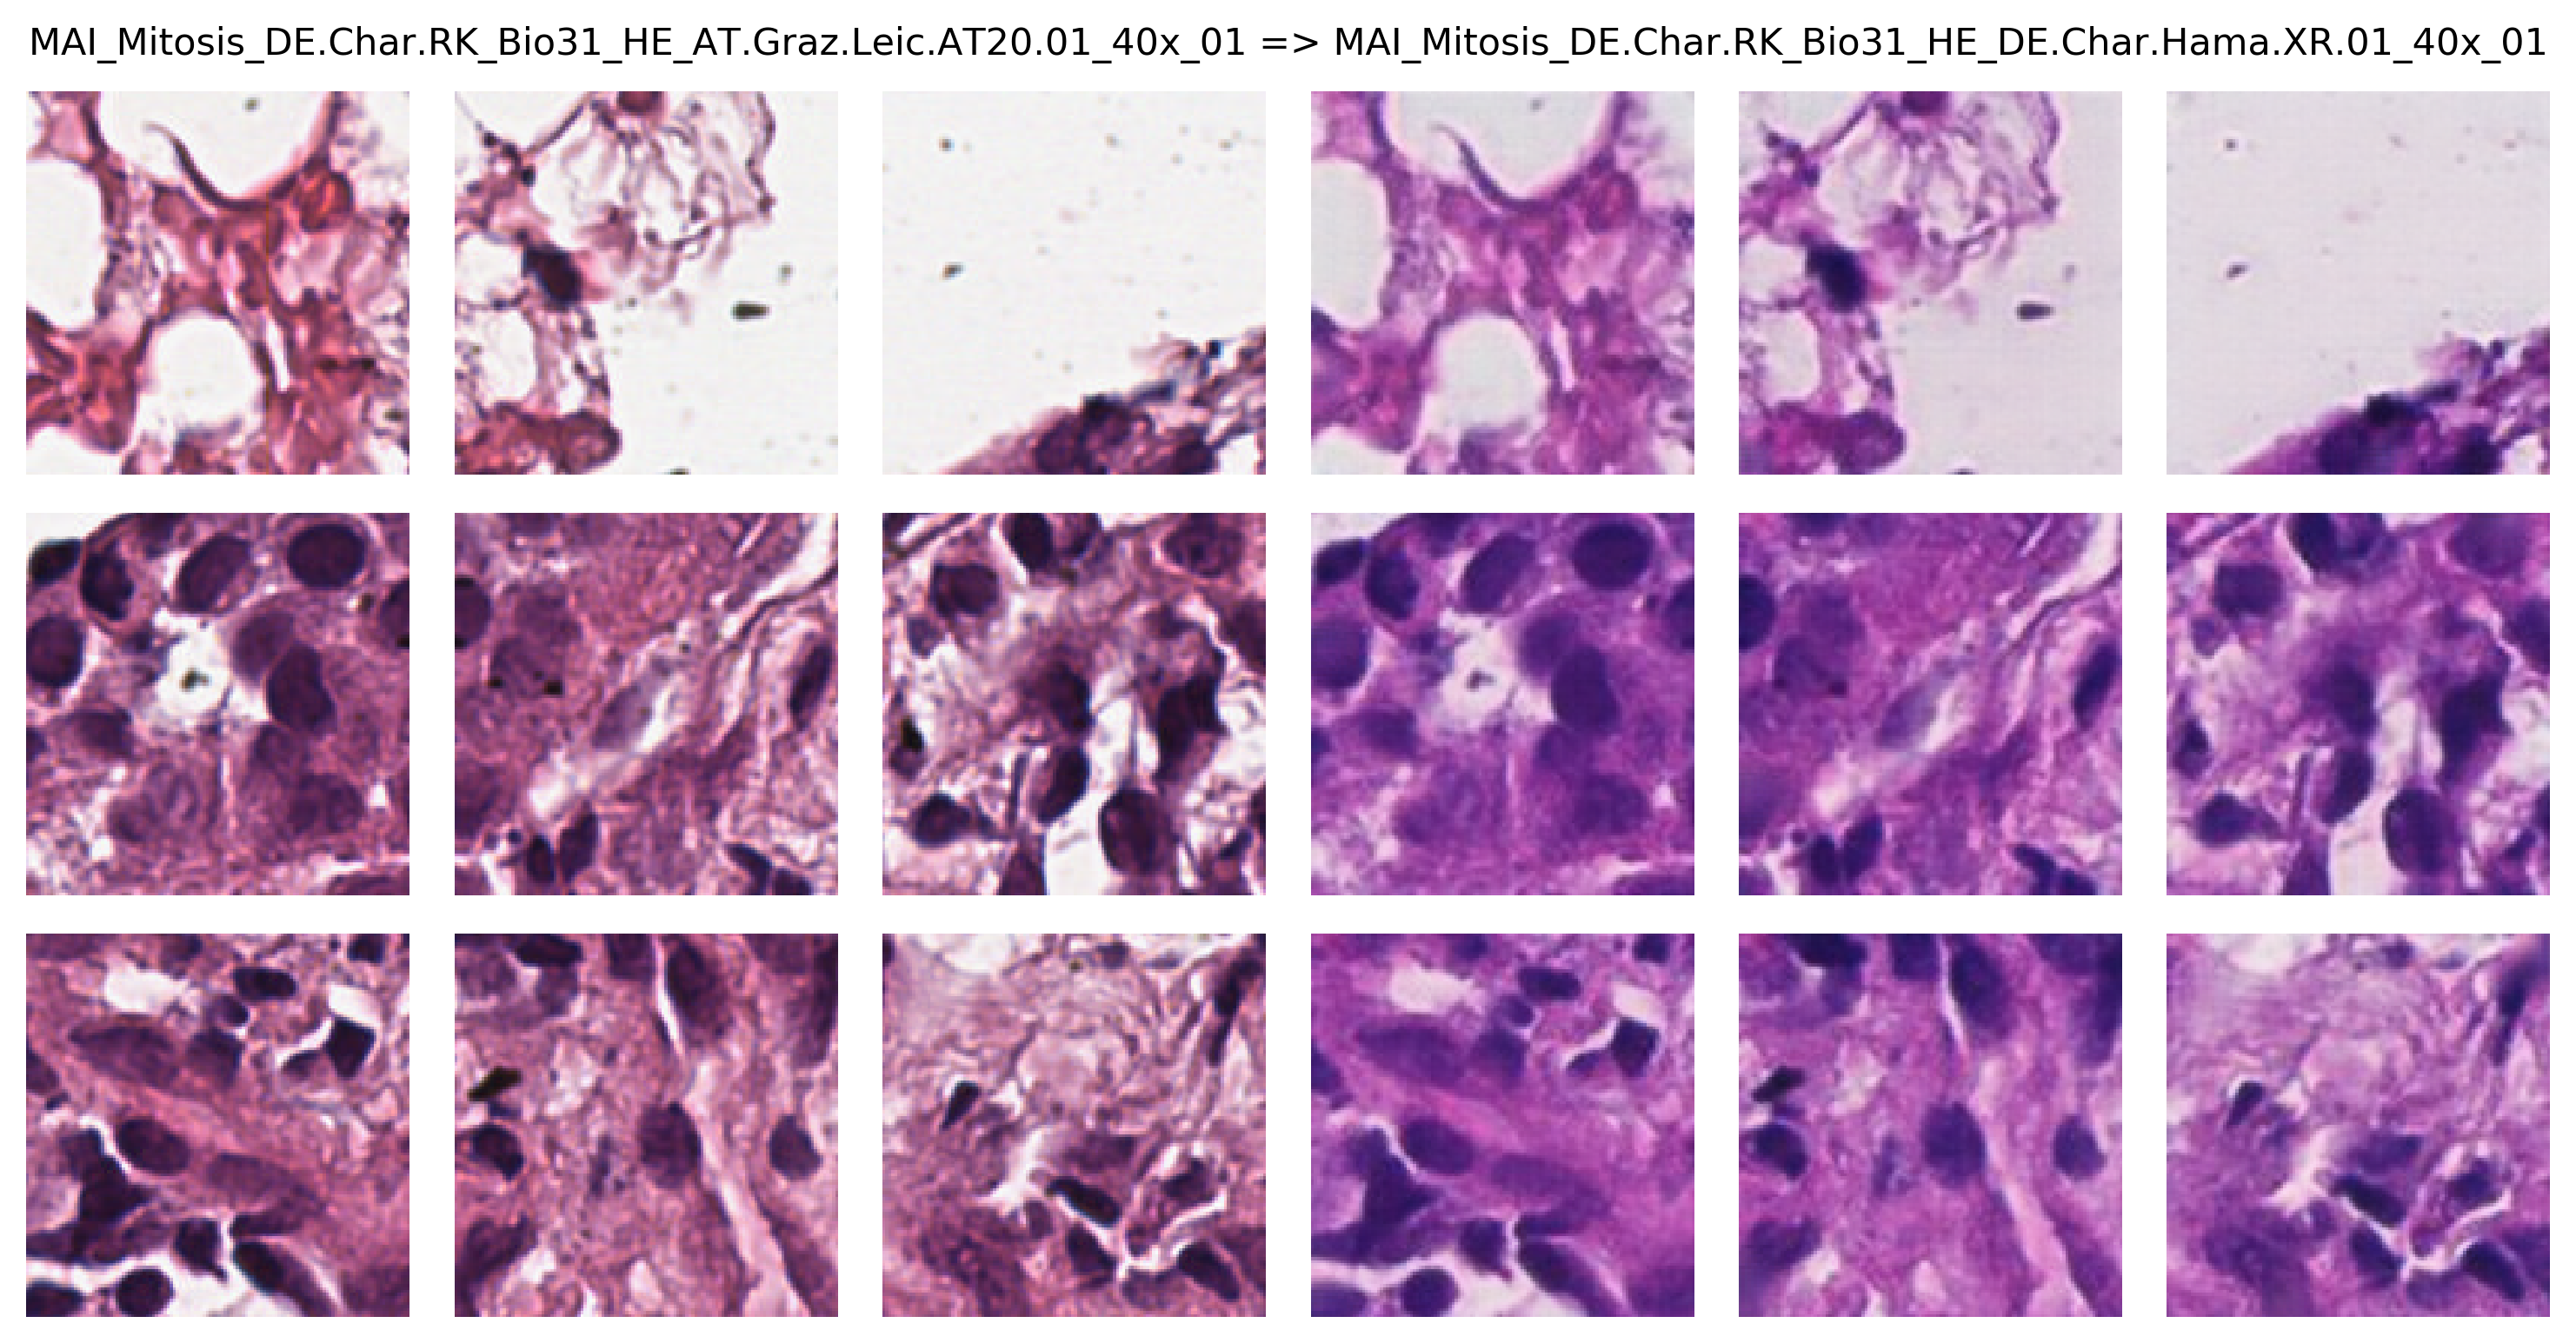

In [107]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

f, axarr = plt.subplots(3, 6, figsize=(10,5))
imgsA = []
for i in range(0, 3):
  for j in range(0, 3):
    image_path = path1 + tiles1[4*i + j+100]
    img = PImage.open(image_path)
    imgsA.append(transform(img).unsqueeze(0))
    axarr[i, j].imshow(img)
    axarr[i, j].set_axis_off()
# f.tight_layout()

# imgsA = torch.cat([transform(PImage.open(path1+name)).unsqueeze(0) for name in tiles1[offset:offset+batch]], dim=0)
imgsA2B = netG_A2B(torch.cat(imgsA, dim=0).to(device1))

for i in range(0, 3):
  for j in range(0, 3):
    axarr[i, j+3].imshow(to_pil(imgsA2B[i*3 + j]))
    axarr[i, j+3].set_axis_off()
f.tight_layout()
f.suptitle('MAI_Mitosis_DE.Char.RK_Bio31_HE_AT.Graz.Leic.AT20.01_40x_01 => MAI_Mitosis_DE.Char.RK_Bio31_HE_DE.Char.Hama.XR.01_40x_01', fontsize=10.3, y=1.02);

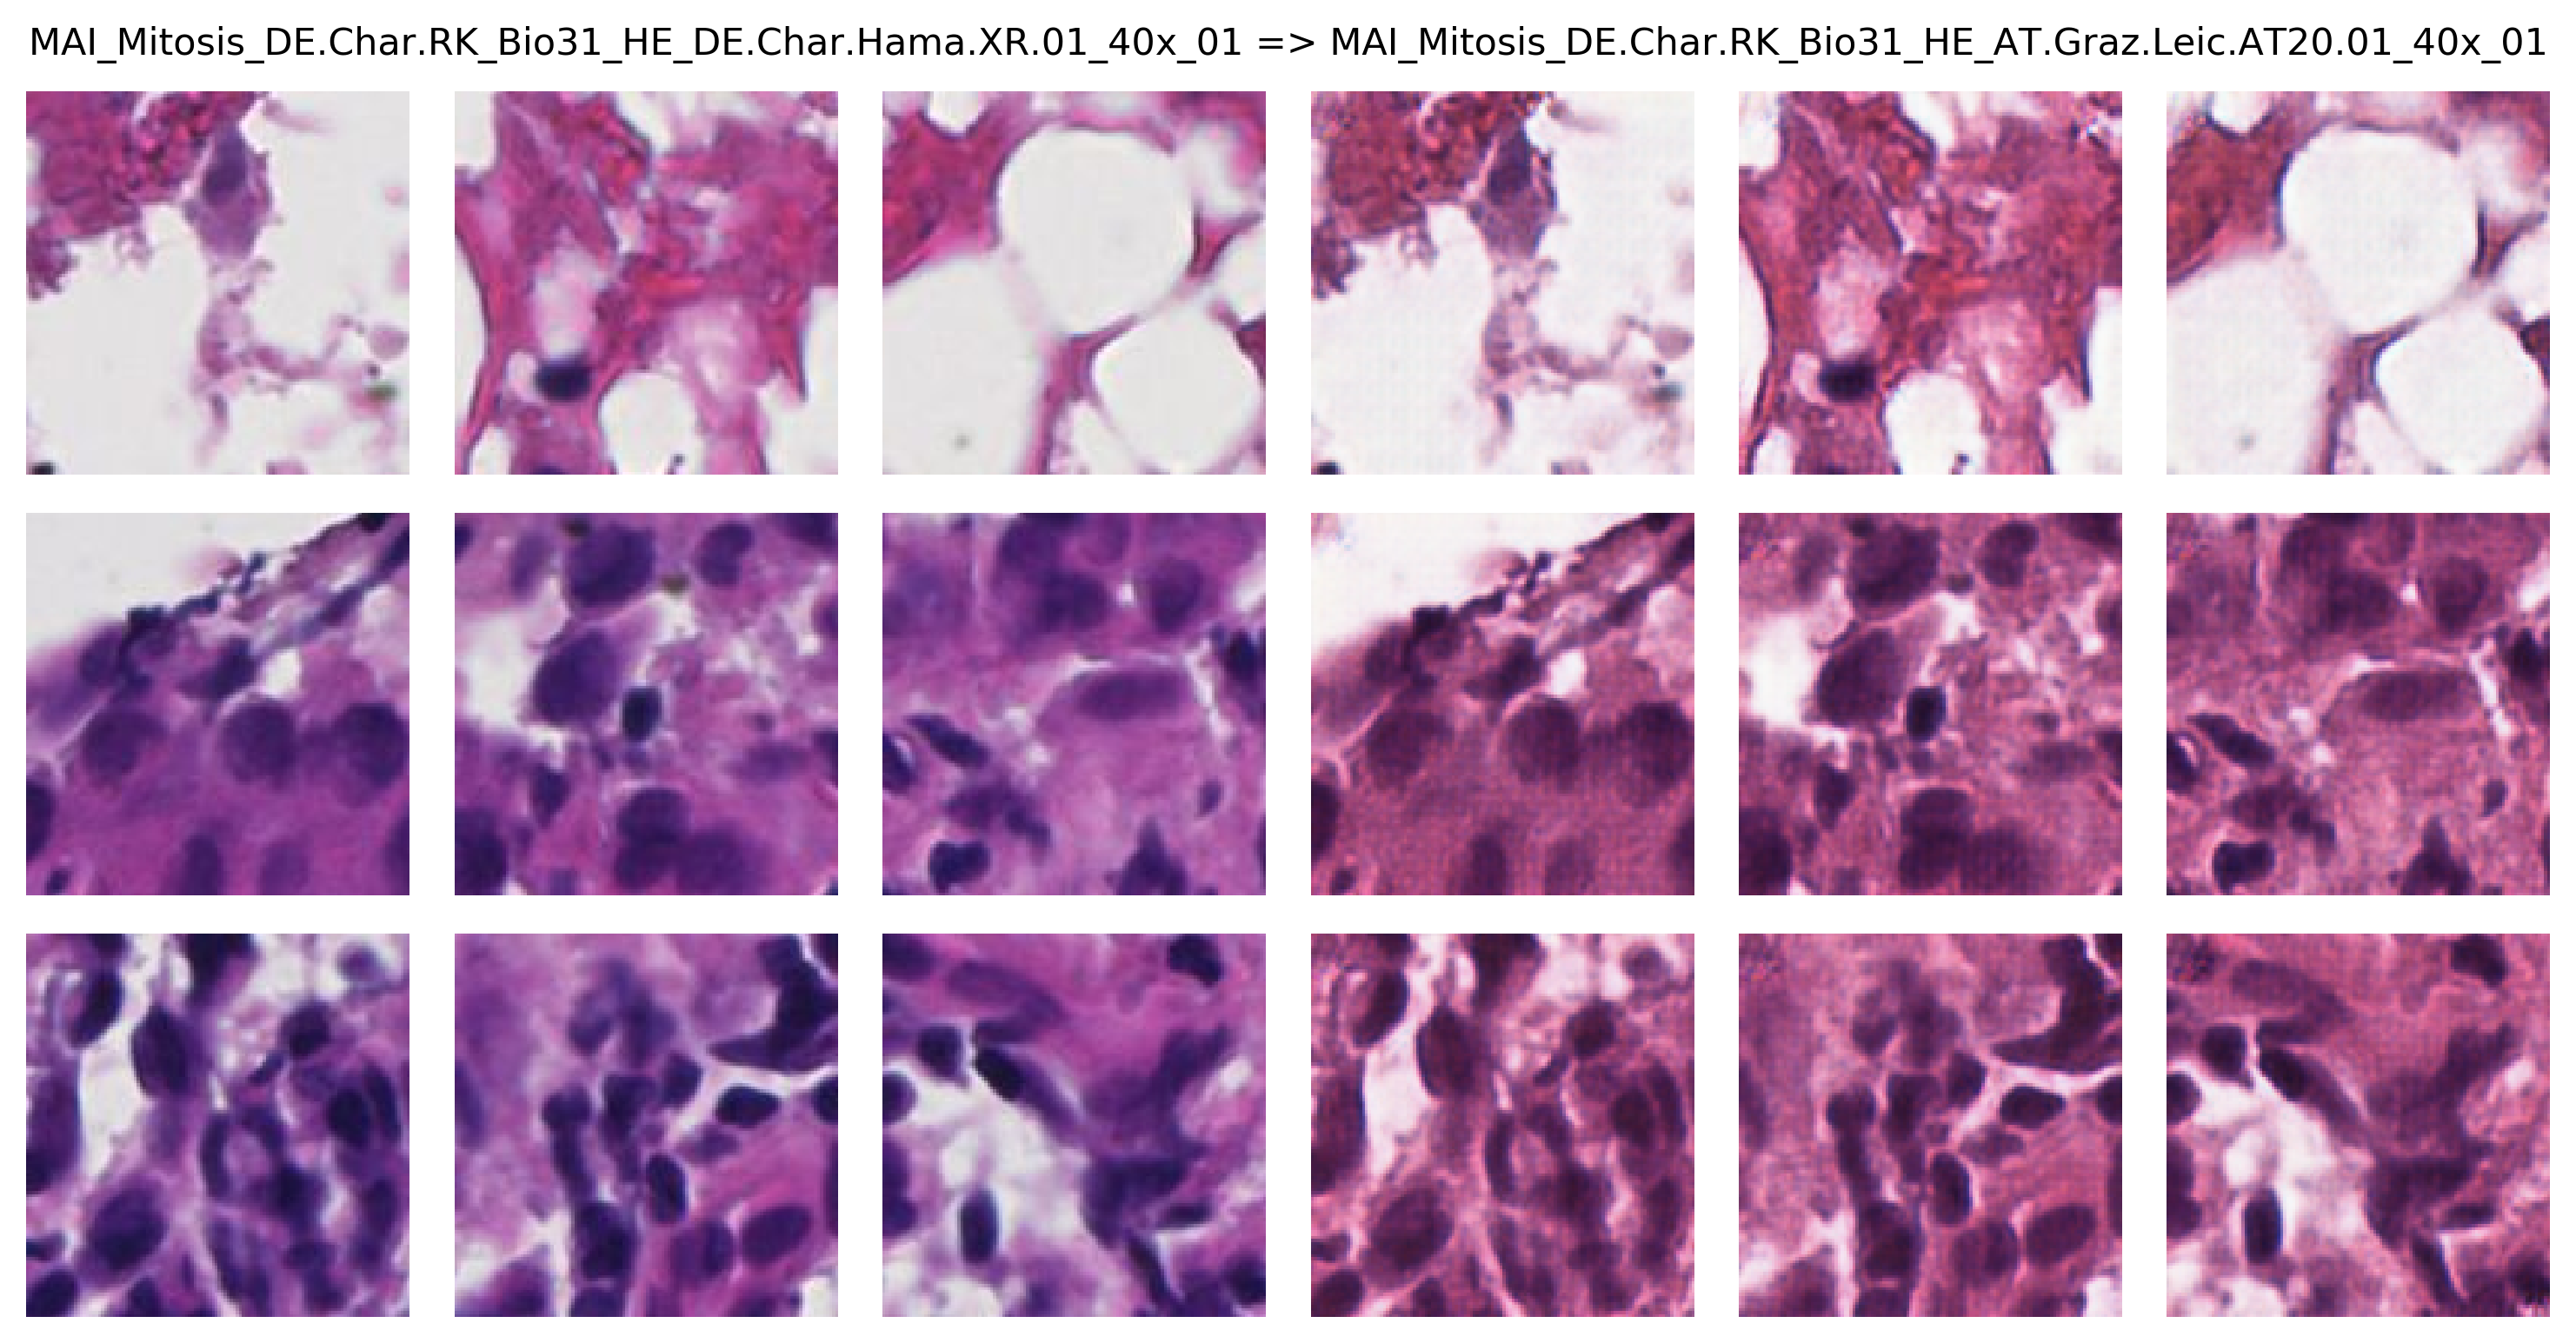

In [108]:
f, axarr = plt.subplots(3, 6, figsize=(10,5))
imgsB = []
for i in range(0, 3):
  for j in range(0, 3):
    image_path = path2 + tiles2[4*i + j+104]
    img = PImage.open(image_path)
    imgsB.append(transform(img).unsqueeze(0))
    axarr[i, j].imshow(img)
    axarr[i, j].set_axis_off()

imgsB2A = netG_B2A(torch.cat(imgsB, dim=0).to(device1))

for i in range(0, 3):
  for j in range(0, 3):
    axarr[i, j+3].imshow(to_pil(imgsB2A[i*3 + j]))
    axarr[i, j+3].set_axis_off()
f.tight_layout()

f.suptitle('MAI_Mitosis_DE.Char.RK_Bio31_HE_DE.Char.Hama.XR.01_40x_01 => MAI_Mitosis_DE.Char.RK_Bio31_HE_AT.Graz.Leic.AT20.01_40x_01', fontsize=10.3, y=1.02);

In [130]:
import pandas as pd
from os.path import join as ospj
from PIL import Image as PImage
import pyvips
import numpy as np
from openslide import open_slide


def merge_patches(idx_file, input_path, output_path, ouput_name, patch_size=128, compression='jpeg', Q=80):
    df = pd.read_csv(idx_file, delimiter='\t')
    
    min_col = df.Column.min()
    max_col = df.Column.max()
    min_row = df.Row.min()
    max_row = df.Row.max()
    
    w = max_col*patch_size
    h = max_row *patch_size

    wsi= np.full((h, w, 3), 255, dtype=np.ubyte)
    print('wsi size: ', wsi.shape)
    
    df = df[df.Keep == 1].copy()
    i = 0
    for name, col, row in zip(df['Tile'], df['Column'], df['Row']):
        y_start = col*patch_size
        y_end = col*patch_size+patch_size
        
        x_start = row*patch_size
        x_end = row*patch_size+patch_size
        img = PImage.open(ospj(input_path,name+'.png'))
        wsi[x_start:x_end, y_start:y_end] = np.array(img, dtype=np.ubyte)
           
    
    slide = pyvips.Image.new_from_memory(wsi, wsi.shape[1], wsi.shape[0], wsi.shape[2], 'uchar')
    slide.tiffsave(ospj(output_path, ouput_name+'.tiff'), compression=compression, Q=Q, tile=True, tile_width=patch_size, tile_height=patch_size, pyramid=True)
    wsi = None


In [132]:
merge_patches('data/mai_mini/output/wsi2/tile_selection.tsv', 'data/mai/wsiT2/',
             'data/mai_mini/output', 'MAI_Mitosis_DE.Char.RK_Bio31_HE_DE.Char.Hama.XR.01_40x_01_translated')

wsi size:  (48512, 55424, 3)


In [42]:
wsi2_df = pd.read_csv('data/mai_mini/output/wsi2/tile_selection.tsv', delimiter='\t')
wsi2_df = wsi2_df[wsi2_df.Keep==1].copy()
wsi2_df.head(10)

,Tile,Width,Height,Keep,Row,Column
995,wsi2_000995,128,128,1,2,127
1429,wsi2_001429,128,128,1,3,127
1499,wsi2_001499,128,128,1,3,197
3263,wsi2_003263,128,128,1,7,225
4953,wsi2_004953,128,128,1,11,179
7512,wsi2_007512,128,128,1,17,134
9049,wsi2_009049,128,128,1,20,369
9426,wsi2_009426,128,128,1,21,312
10785,wsi2_010785,128,128,1,24,369
10895,wsi2_010895,128,128,1,25,45


In [47]:
wsi2_df.describe()

,Width,Height,Keep,Row,Column
count,26808.0,26808.0,26808.0,26808.000000,26808.000000
mean,128.0,128.0,1.0,196.274694,217.231050
std,0.0,0.0,0.0,67.851480,75.248744
min,128.0,128.0,1.0,2.000000,4.000000
25%,128.0,128.0,1.0,140.000000,162.000000
50%,128.0,128.0,1.0,177.000000,213.000000
75%,128.0,128.0,1.0,261.000000,274.000000
max,128.0,128.0,1.0,370.000000,424.000000
